In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
ALL_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [4]:
FIG_PREFIX = 'revision2/protein'

In [5]:
trigram_dir = '../result/trigram_result/result/protein_trigram_result'
vggraph_dir = '../result/vggraph_result/protein_vggraph_greedy_revision'

In [6]:
root_dir = '../result/protein_result'
root_best_dir = '../result/protein_best_result'
root_lpms_dir = '../result/protein_lpms_result'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']
rev_dir = '../result/revision/protein'

In [22]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    if 'VGGraph-Greedy' in name:
        name = 'VGGRAPH'
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if 'Trigram' in name:
        fields[2] = '-1'
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{row['num_threads']}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        if 'VGGraph-Greedy' in row['name']:
            space_file += f"{row['name'].lower().replace('-', '_')}_t{int(row['num_threads'])}"
        else:
            space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        if 'Trigram' not in name:
            space_file += f"_c{row['selectivity']}"
        if 'FREE' in name or 'VG' in name:
            space_file += f"_n{int(row['gram_size'])}"
    if 'key_upper_bound' in row:
            space_file += f"_{int(row['key_upper_bound'])}"
            fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [8]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        # print(f'Error reading file {fullname}')
        pass
    return -1

In [9]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [10]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [18]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df = summary_df.fillna(-1)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [12]:
res_dfrev = build_result_df(rev_dir)

In [13]:
res_df1 = build_result_df(root_dir, True)

In [14]:
res_lpms_df = build_result_df(root_lpms_dir)

In [15]:
res_best_df = build_result_df(root_best_dir)

In [16]:
res_df1.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count',
       'compute_size'],
      dtype='object')

In [24]:
res_trigram = build_result_df(trigram_dir)
res_vggraph = build_result_df(vggraph_dir)

In [25]:
res_df = pd.concat([res_trigram, res_vggraph, res_dfrev, res_df1, res_best_df, res_lpms_df], ignore_index=True)

In [26]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['name', 'gram_size'])

In [27]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,method
73,VGGraph-Greedy,16,4,0.7,1003,-1.0,1000.0,3.810000e-07,7.1575,7.1575,...,127.715955,127.745441,134.902941,65947343,65947.343,660192,1040600,0.989989,0.010011,VGGraph


In [30]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None
# lims = [30, 50, 100, 500]#, 1000, 10000]
lims = [ 50, 100, 500]#, 1000, 10000]
for up_lim in lims:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count    
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(up_lim)+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3g}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\")
        else:
            print("\\\\ \midrule")
            
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)

    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
summary_df['name'] = [ nm.split('-')[0] for nm in summary_df['name'].to_list()]

\multirow{5}{*}{\bf{50}}& \best  & \cellcolor{green!50}{141.5} & 400 & 0.931 & 9.4 & \cellcolor{yellow!50}{0.00826} \\
& \free  & 150.9 & 2 & \cellcolor{green!50}{0.179} & 1.5 & 0.00689 \\
& \lpms  & 151.8 & 14 & 0.263 & 26.2 & 0.00708 \\
& \trigram  & 156.0 & \cellcolor{green!50}{0} & 0.212 & 4.5 & 0.00649 \\
& \vgg  & 150.8 & 2 & 1.037 & \cellcolor{green!50}{0.6} & 0.00679 \\ \midrule
\multirow{5}{*}{\bf{100}}& \best  & \cellcolor{green!50}{139.7} & 856 & 0.967 & 14.9 & \cellcolor{yellow!50}{0.0089} \\
& \free  & 149.2 & 2 & \cellcolor{green!50}{0.191} & \cellcolor{green!50}{5.7} & 0.0072 \\
& \lpms  & 151.8 & 14 & 0.263 & 26.2 & 0.00708 \\
& \trigram  & 155.0 & \cellcolor{green!50}{0} & 0.199 & 8.1 & 0.00657 \\
& \vgg  & 147.2 & 3 & 1.041 & 18.2 & 0.00732 \\ \midrule
\multirow{5}{*}{\bf{500}}& \best  & 139.7 & 856 & 0.967 & 14.9 & 0.0089 \\
& \free  & 149.2 & 2 & \cellcolor{green!50}{0.191} & \cellcolor{green!50}{5.7} & 0.0072 \\
& \lpms  & 151.8 & 14 & 0.263 & 26.2 & 0.00708 \\
& \

In [31]:
summary_df

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,max_key
0,BEST,16,-1,0.70,50,50,1000.0,3.996470e+02,0.004793,399.652000,...,141.516582,141.545800,541.197800,87395796,87395.796,721672,931360,0.991742,0.008258,50
1,FREE,16,2,0.15,38,50,0.0,1.911520e+00,0.569952,2.481480,...,150.908946,150.940420,153.421900,104698218,104698.218,721674,178656,0.993107,0.006893,50
2,LPMS,16,-1,-1.00,40,50,NaN,1.394920e+01,-1.000000,13.949200,...,151.794122,151.823392,165.772592,100807402,100807.402,713462,263012,0.992923,0.007077,50
3,Trigram,16,3,-1.00,50,50,1000.0,1.232130e-03,0.278227,0.279459,...,155.991090,156.022353,156.301812,111187159,111187.159,722024,212164,0.993506,0.006494,50
4,VGGraph,16,2,0.10,50,50,1000.0,3.910000e-07,1.707440,1.707440,...,150.730931,150.760391,152.467831,106312149,106312.149,721674,1036640,0.993212,0.006788,50
5,BEST,16,-1,0.70,100,100,1000.0,8.555980e+02,0.007895,855.606000,...,139.703895,139.732659,995.338659,81070736,81070.736,721670,966512,0.991098,0.008902,100
6,FREE,16,2,0.20,65,100,0.0,1.931370e+00,0.557597,2.488970,...,149.197701,149.229286,151.718256,100253593,100253.593,721667,190532,0.992802,0.007198,100
7,LPMS,16,-1,-1.00,40,100,NaN,1.394920e+01,-1.000000,13.949200,...,151.794122,151.823392,165.772592,100807402,100807.402,713462,263012,0.992923,0.007077,100
8,Trigram,16,3,-1.00,100,100,1000.0,1.554790e-03,0.328552,0.330107,...,154.947144,154.978267,155.308374,109854714,109854.714,722024,199060,0.993427,0.006573,100
9,VGGraph,16,6,0.70,64,100,1000.0,3.400000e-07,2.621410,2.621410,...,147.129617,147.158966,149.780376,98647237,98647.237,722024,1041376,0.992681,0.007319,100


In [32]:
import matplotlib
print(matplotlib.__version__)


3.5.3


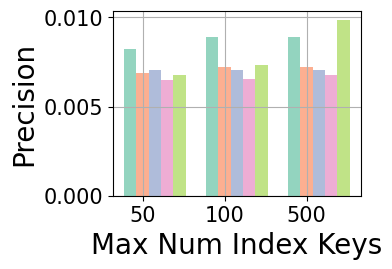

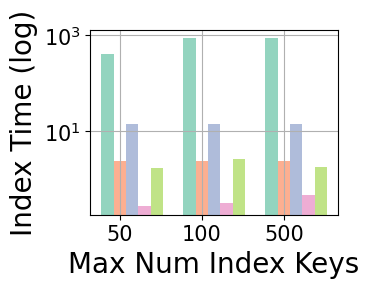

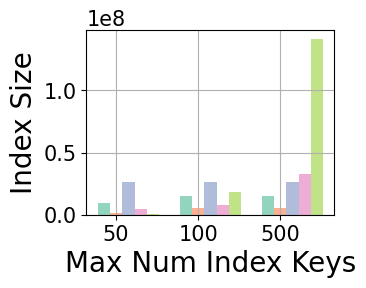

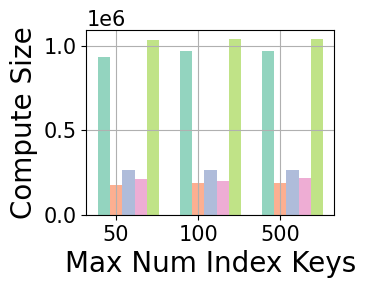

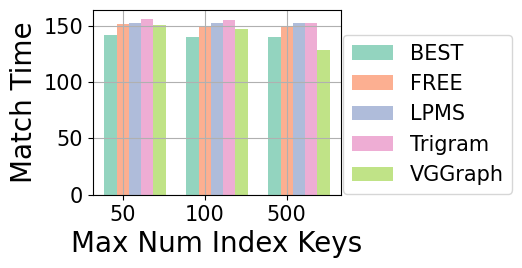

In [79]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size', 'overall_match_time']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    # fig, ax = plt.subplots(figsize=(10,4.2))
    fig, ax = plt.subplots(figsize=(3.2, 2.4))

    x = np.arange(len(lims))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0
    for method, color in zip(ALL_METHODS, colors):
        curr = summary_df.loc[summary_df["name"] == method]#.sort_values('name')
        
        X = curr['key_upper_bound']
        
        # fig, ax = plt.subplots(layout='constrained')
        offset = width * multiplier- width
        Y = curr[col].to_numpy()
        rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)

        multiplier += 1
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys')

    ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])
    
    # plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
    if col == 'overall_match_time':
        plt.legend(loc='lower center', ncol=1, bbox_to_anchor=(1.35, -0.05))
    # plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.8))
    # plt.legend(loc='lower center', ncol=3)#, fancybox=True, framealpha=0.2)
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

('BEST', -1)
('BEST-parallel', -1)
('FREE-parallel', 2)
('FREE-parallel', 4)
('FREE-parallel', 6)
('LPMS-DETER', -1)
('Trigram', 3)


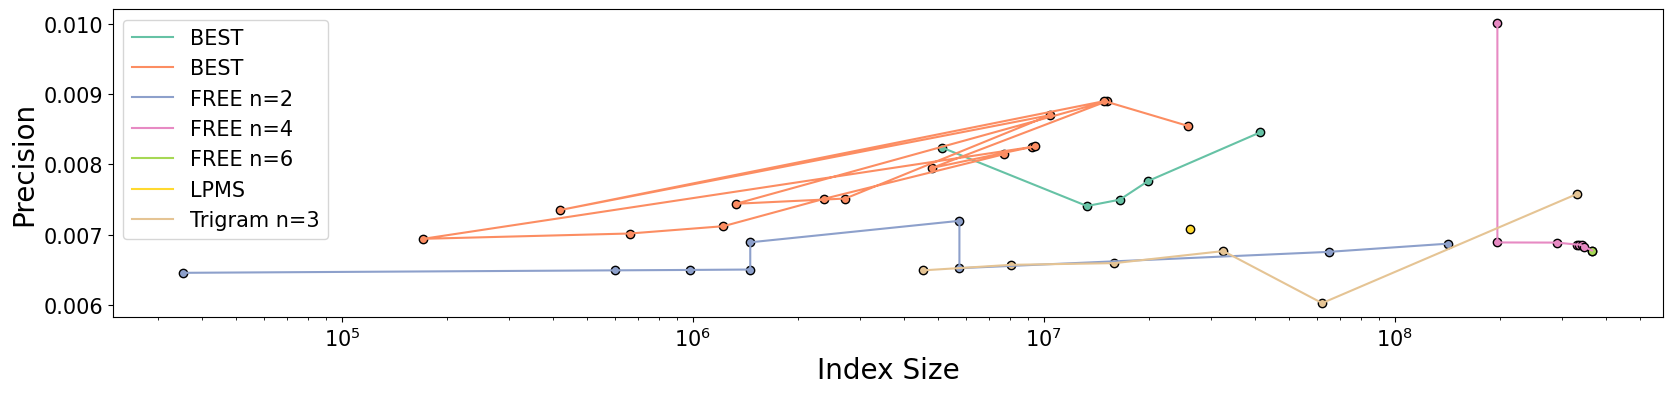

In [34]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['index_size']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Size')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrSize_prec.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['overall_index_time']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Construction Time')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrTime_prec.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# explore the distribution of number of keys and number

groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('num_after_filter')

# inset Axes....
x1, x2, y1, y2 = 0,5000, 0, 30000000  # subregion of the original image
axins = ax.inset_axes(
    [0.3, 0.4, 0.67, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend()
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')

new_groups = new_res_df.groupby(['name', 'gram_size'])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color)
    ax.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--

ax.set_xlabel('num_keys')
ax.set_ylabel('precision')

ax.set_xlim([0, 5000])
plt.legend(loc="lower right", labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec.pdf', bbox_inches='tight')
plt.show()

In [ ]:
new_res_df[new_res_df['num_keys'] < 5000].sort_values(by='num_after_filter', ascending=True)

In [ ]:
data = np.sort(new_res_df['num_keys'].to_numpy())
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [ ]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)
print(idxs)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 1))
ax.scatter(data, [10] * len(data))
bins = [np.min(data)-1]
for idx in prec_idxs[-9:]:
    print(f'idx[{idx}], between {data[idx]} and {data[idx+1]}')
    curr_x = (data[idx] + data[idx + 1])/2
    bins.append(curr_x)
    ax.axvline(x=curr_x, color='red')
bins = np.sort(bins)
bins = np.append(bins, int(np.max(data)*1.01))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))
ax.set_xlim([0, 10000])

for idx in prec_idxs[-9:]:
    if data[idx] < 10000:
        print(f'idx[{idx}], between {data[idx]} and {data[idx+1]} at {(data[idx] + data[idx + 1])/2}')
        curr_x = (data[idx] + data[idx + 1])/2
        ax.axvline(x=curr_x, color='red')

In [ ]:
print(bins)

In [ ]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None
for up_lim in bins[2:]:
    up_lim = np.ceil(up_lim)
    # print(up_lim)
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    curr_group = curr_group.sort_values(by='num_keys')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count
    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)

    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(int(up_lim))+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ \cline{2-7}")
        else:
            print("\\\\ \hline")
    # print(curr_group)

In [ ]:
summary_df

In [ ]:
for up_lim in bins[1:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    print(up_lim)
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    print(curr_group)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black', alpha=0.5)
print(np.log(bins))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gca().set_xscale("log")
ax.set_xticks(bins)
ax.set_xticklabels([int(b) for b in bins], rotation=45)

ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    ax2.plot(X, Y, c=color)
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    sc = ax2.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    if name[0] == 'FREE-parallel':
        labs = (new_group['selectivity'].unique())
        labs = np.sort(labs)
        handles, labels = sc.legend_elements(prop="sizes", alpha=0.4,num=4)     
        # labels = new_group['selectivity'].unique()    
        # legend = ax.legend(handles, [" " , "Selectivity\nThreshold"," " ,  " "], title="Size")
        # ax.legend(*sc.legend_elements("sizes", num=4, alpha=0.5), loc='center right')

    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('Precision')
ax.set_ylabel('Index Count')
ax.set_xlabel('num_keys')
plt.legend(labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec_hist.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black');
# plt.gca().set_xscale("log")
ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1
    if name == 'FREE-parallel':
        curr_new_group = new_group[new_group['gram_size'] == 4]
    else:
        curr_new_group = new_group
    X = curr_new_group['num_keys']
    Y = curr_new_group['precision']
    ax2.plot(X, Y, c=color)
    ax2.scatter(X, Y, marker='o', label=curr_new_group['name'].to_list()[0], c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*curr_new_group['selectivity'].to_numpy())
    for g, s, x, y in zip(curr_new_group['gram_size'], curr_new_group['selectivity'], X, Y):
        ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('precision')
ax.set_ylabel('count')
ax.set_xlabel('num_keys')
ax.set_xlim([0, 6000])
plt.legend(labelspacing=2)

In [ ]:
# bin them by number of 
BIN_NUM = 10
new_res_df.hist(column='num_keys', bins=BIN_NUM)
heights, bins = np.histogram(data, bins=BIN_NUM)

In [ ]:
_, bins = np.histogram(np.log10(data + 1), bins=BIN_NUM)
plt.hist(data, bins=10**bins);
plt.gca().set_xscale("log")

In [ ]:
edges = 10**bins
prev = 0
for b in edges:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True)[['name', 'num_keys', 'selection_time', 'num_after_filter']])
    prev = b
print([int(e) for e in edges])

In [ ]:
sns.histplot(new_res_df['num_keys'], bins=BIN_NUM, log_scale=True)

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x = new_res_df['num_keys'].to_numpy()
n, bins, patches = plt.hist(x, histedges_equalN(x, 20))

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [ ]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [ ]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

In [ ]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

In [ ]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()